In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag, FreqDist

from wordcloud import WordCloud

import pickle

pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300 # max width of a column

# set random seed to ensure reproducible results
np.random.seed(42)

#import custom_code.model_with_cv as custom_cv

%matplotlib inline

## Prepare data for modeling

### Set up functions for preprocessing

In [2]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [3]:
# Added 'us' to stopwords, because the lemmatizer reduces it to 'u'
sw = stopwords.words('english') + ['us']

def word_processor(comment, stopword_list=sw):
    # tokenize (simultaneously removes punctuation)
    tokenizer = RegexpTokenizer(pattern="([a-zA-Z]+(?:'[a-z]+)?)")
    words = tokenizer.tokenize(comment)

    # lowercase and remove stopwords
    words = [word.lower() for word in words if word.lower() not in stopword_list]
    
    # lemmatize (accounting for part of speech)
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word[0], get_wordnet_pos(word[1])) 
             for word in pos_tag(words)]

    return ' '.join(words)

### Complete row-wise data cleaning and transformations

In [4]:
train_df = pd.read_csv('data/train_df.csv')

In [5]:
%%time
train_df['proc_text'] = train_df['comment_text'].map(word_processor)

CPU times: user 17min 17s, sys: 12.9 s, total: 17min 30s
Wall time: 17min 37s


In [6]:
train_df.head()

,id,comment_text,target,proc_text
0,6130267,"I don't think I would be acting like a tough guy in front of my kid with a bat if the other guy had a gun.doesn't seem like much of a fight to me,but then most people don't bring bats to gun fights",1,think would act like tough guy front kid bat guy gun seem like much fight people bring bat gun fight
1,6120855,"The Left will always defends scum like this, as long as their politics are ""correct"". \n\nYet, Democrats and the Left are the ones that claim to want to defend women's rights ... the truth tells a far different story.",1,leave always defend scum like long politics correct yet democrats left one claim want defend women's right truth tell far different story
2,6233267,"I think they will be fighting Hawaiian, Alaska/Virgin America, Delta, United , American Airlines for gate space during peak times at HNL. They all use or will be using medium size aircraft and fight with Wide bodies during this period. State is retrofitting the diamond head concourse for Island...",1,think fight hawaiian alaska virgin america delta united american airline gate space peak time hnl use use medium size aircraft fight wide body period state retrofit diamond head concourse island air would accommodate sw enter inter island market somebody pay island air go
3,452907,"Bad: As pepper spray does not threaten serious bodily harm, nor a reasonable possibility of death, you would probably be prosecuted for use of unjustifiable deadly force. And I was relieved to see you describe yourself as an ""ex-cop"". I would be fearful of having to deal with you if you were ...",1,bad pepper spray threaten serious bodily harm reasonable possibility death would probably prosecute use unjustifiable deadly force relieve see describe ex cop would fearful deal still force
4,5494517,The fascist movements that threaten us is these twisted ugly leftist hate groups trying to destroy democracy and freedom of religion and freedom of speech disguised as liberalism?.\nYou accept no other opinion but your own.\nYou would destroy freedom instead of admitting you are wrong.\nWe are t...,1,fascist movement threaten twist ugly leftist hate group try destroy democracy freedom religion freedom speech disguise liberalism accept opinion would destroy freedom instead admit wrong try stop islamist take country culture way life get blow either age f u lefty fascism think gonna let destroy...


## Set up train-test split and preprocessing pipelines

In [7]:
y = train_df['target']
X = train_df['proc_text']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
X_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 507613 entries, 140779 to 121958
Series name: proc_text
Non-Null Count   Dtype 
--------------   ----- 
507613 non-null  object
dtypes: object(1)
memory usage: 7.7+ MB


### Preprocessing pipeline

Need to set up pipeline to perform preprocessing steps to each split of the data

In [9]:
subpipe_text = Pipeline(steps=[
    ('cv', CountVectorizer())
])

### Prepare pipelines for cross-validation testing

In [10]:
# Specify scoring method that will be used to evaluate all models
scoring="f1"

In [11]:
dummy_model_pipe = Pipeline(steps=[
    ('subpipe_text',subpipe_text),
    ('dum_class', DummyClassifier(strategy='uniform'))
])

In [12]:
mnb_model_pipe = Pipeline(steps=[
    ('subpipe_text',subpipe_text),
    ('mnb', MultinomialNB())
])

In [13]:
logreg_model_pipe = Pipeline(steps=[
    ('subpipe_text',subpipe_text),
    ('ss', StandardScaler(with_mean=False)),
    ('logreg', LogisticRegression(max_iter=10000))
])

In [24]:
### Using this class (From Flatiron School Lecture 51) to conduct 
### cross-validation, store, and display results

class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True, scoring="accuracy"):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        self.cv_preds = None

        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring=scoring)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def plot_cv_confusion_matrix(self, X=None, y=None, kfolds=10):
        '''
        Plot confusion matrix using predictions obtained by cross-validation (using cross_val_predict)
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y
        
        self.cv_preds = cross_val_predict(self.model, cv_X, cv_y, cv=kfolds)

        #labels=self.model.classes_
        labels=[0,1]
        cm = confusion_matrix(cv_y, self.cv_preds, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot();


        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} {scoring}
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

## Run Baseline DummyClassifier

In [26]:
dummy_cv = ModelWithCV(dummy_model_pipe, model_name='dummy_model_pipe', 
                       X=X_train, y=y_train, scoring=scoring)

CV Results for `dummy_model_pipe` model:
            0.50027 ± 0.00364 f1
        


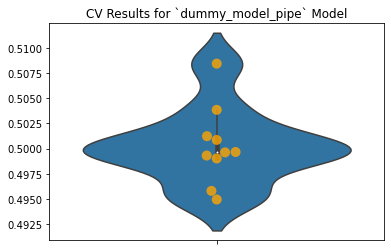

In [27]:
dummy_cv.print_cv_summary()
fig, ax = plt.subplots()

dummy_cv.plot_cv(ax=ax);

              precision    recall  f1-score   support

           0       0.50      0.50      0.50    253665
           1       0.50      0.50      0.50    253948

    accuracy                           0.50    507613
   macro avg       0.50      0.50      0.50    507613
weighted avg       0.50      0.50      0.50    507613



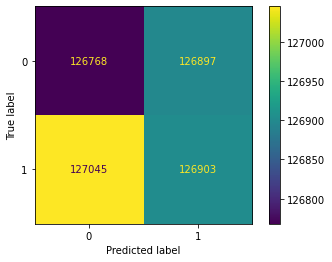

In [28]:
dummy_cv.plot_cv_confusion_matrix();

# print the classification report to see model metrics
print(classification_report(y_train, dummy_cv.cv_preds, zero_division=0))

In [29]:
mnb_cv = ModelWithCV(mnb_model_pipe, model_name='mnb_model_pipe', 
                     X=X_train, y=y_train, scoring=scoring)

CV Results for `mnb_model_pipe` model:
            0.75294 ± 0.00202 f1
        


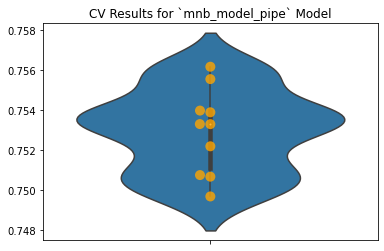

In [30]:
mnb_cv.print_cv_summary()
fig, ax = plt.subplots()

mnb_cv.plot_cv(ax=ax);

              precision    recall  f1-score   support

           0       0.78      0.65      0.71    253665
           1       0.70      0.81      0.75    253948

    accuracy                           0.73    507613
   macro avg       0.74      0.73      0.73    507613
weighted avg       0.74      0.73      0.73    507613



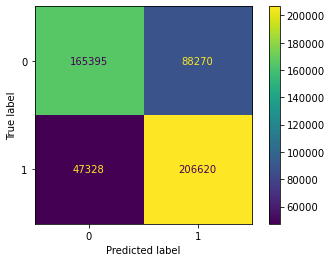

In [31]:
mnb_cv.plot_cv_confusion_matrix();

# print the classification report to see model metrics
print(classification_report(y_train, mnb_cv.cv_preds, zero_division=0))

In [58]:
logreg_defaults_cv = ModelWithCV(logreg_model_pipe, model_name='logreg_defaults_model_pipe', 
                                 X=X_train, y=y_train, scoring=scoring)

CV Results for `logreg_defaults_model_pipe` model:
            0.74955 ± 0.00125 f1
        


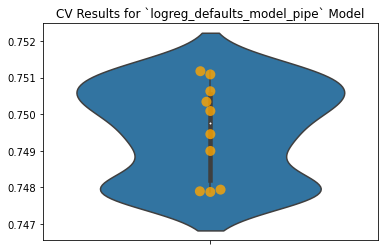

In [59]:
logreg_defaults_cv.print_cv_summary()

fig, ax = plt.subplots()
logreg_defaults_cv.plot_cv(ax=ax);

              precision    recall  f1-score   support

           0       0.74      0.79      0.77    253665
           1       0.78      0.72      0.75    253948

    accuracy                           0.76    507613
   macro avg       0.76      0.76      0.76    507613
weighted avg       0.76      0.76      0.76    507613



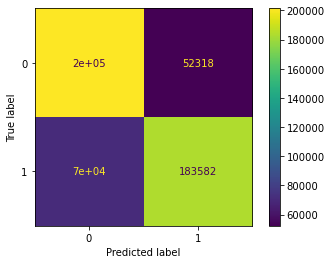

In [60]:
logreg_defaults_cv.plot_cv_confusion_matrix();

# print the classification report to see model metrics
print(classification_report(y_train, logreg_defaults_cv.cv_preds, zero_division=0))

In [40]:
params = {
    'subpipe_text__cv__min_df': (0.0001, 0.001, 0.01) # control number of ngrams (smaller proportion = less features)
    ,'mnb__alpha': (1, 1e-2, 1e-3)
}

In [41]:
mnb_gs_cv1 = GridSearchCV(estimator=mnb_model_pipe, scoring=scoring, param_grid=params, cv=3, n_jobs=-2, verbose=2)
mnb_gs_cv1.fit(X_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('subpipe_text',
                                        Pipeline(steps=[('cv',
                                                         CountVectorizer())])),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-2,
             param_grid={'mnb__alpha': (1, 0.01, 0.001),
                         'subpipe_text__cv__min_df': (0.0001, 0.001, 0.01)},
             scoring='f1', verbose=2)

In [43]:
mnb_gs_cv1.best_params_

{'mnb__alpha': 0.001, 'subpipe_text__cv__min_df': 0.0001}

In [44]:
mnb_gs_cv1.best_score_

0.7529388146881663

In [67]:
params = {
    'subpipe_text__cv__min_df': (0.0001, 0.001) # control number of ngrams (smaller proportion = less features)
    ,'logreg__penalty': ['l2', 'elasticnet']
    ,'logreg__C': [0.1, 0.001]
    ,'logreg__solver': ['saga']
    ,'logreg__l1_ratio': [0.5]
}

In [68]:
%%time
logreg_gs_cv1 = GridSearchCV(estimator=logreg_model_pipe, scoring=scoring, 
                             param_grid=params, cv=3, n_jobs=-2, verbose=2)
logreg_gs_cv1.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/anaconda3/envs/nlp-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/anaconda3/envs/nlp-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/anaconda3/envs/nlp-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/anaconda3/envs/nlp-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/anaconda3/envs/nlp-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got 

[CV] END logreg__C=0.1, logreg__l1_ratio=0.5, logreg__penalty=l2, logreg__solver=saga, subpipe_text__cv__min_df=0.0001; total time= 2.2min
[CV] END logreg__C=0.1, logreg__l1_ratio=0.5, logreg__penalty=elasticnet, logreg__solver=saga, subpipe_text__cv__min_df=0.001; total time=20.3min
[CV] END logreg__C=0.001, logreg__l1_ratio=0.5, logreg__penalty=elasticnet, logreg__solver=saga, subpipe_text__cv__min_df=0.001; total time= 6.0min
[CV] END logreg__C=0.1, logreg__l1_ratio=0.5, logreg__penalty=l2, logreg__solver=saga, subpipe_text__cv__min_df=0.0001; total time= 4.2min
[CV] END logreg__C=0.001, logreg__l1_ratio=0.5, logreg__penalty=l2, logreg__solver=saga, subpipe_text__cv__min_df=0.0001; total time= 1.2min
[CV] END logreg__C=0.001, logreg__l1_ratio=0.5, logreg__penalty=l2, logreg__solver=saga, subpipe_text__cv__min_df=0.0001; total time= 1.3min
[CV] END logreg__C=0.001, logreg__l1_ratio=0.5, logreg__penalty=l2, logreg__solver=saga, subpipe_text__cv__min_df=0.0001; total time= 1.2min
[CV] 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('subpipe_text',
                                        Pipeline(steps=[('cv',
                                                         CountVectorizer())])),
                                       ('ss', StandardScaler(with_mean=False)),
                                       ('logreg',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-2,
             param_grid={'logreg__C': [0.1, 0.001], 'logreg__l1_ratio': [0.5],
                         'logreg__penalty': ['l2', 'elasticnet'],
                         'logreg__solver': ['saga'],
                         'subpipe_text__cv__min_df': (0.0001, 0.001)},
             scoring='f1', verbose=2)

In [69]:
# import pickle
# # save the model to disk
# filename = 'data/logreg_gs_cv1_model.sav'
# pickle.dump(logreg_gs_cv1, open(filename, 'wb'))

In [70]:
# import pickle
# # retrieve the model from disk
# filename = 'data/logreg_gs_cv1_model.sav'
# logreg_gs_cv1 = pickle.load(open(filename, 'rb'))

In [71]:
logreg_gs_cv1.best_params_

{'logreg__C': 0.001,
 'logreg__l1_ratio': 0.5,
 'logreg__penalty': 'elasticnet',
 'logreg__solver': 'saga',
 'subpipe_text__cv__min_df': 0.0001}

In [72]:
logreg_gs_cv1.best_score_

0.7951394180749527

In [20]:
final_text = Pipeline(steps=[
    ('cv', CountVectorizer(min_df=0.0001))
])

final_model = LogisticRegression(
    C=0.001,
    penalty='elasticnet',solver='saga',
    l1_ratio=0.5,
    max_iter=10000
)

final_model_pipe = Pipeline(verbose=True, steps=[
    ('final_text',final_text),
    ('ss', StandardScaler(with_mean=False)),
    ('final_model', final_model)
])

In [21]:
%%time
final_model_pipe.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 3) Processing final_text, total=  10.6s
[Pipeline] ................ (step 2 of 3) Processing ss, total=   0.8s
[Pipeline] ....... (step 3 of 3) Processing final_model, total=30.1min
CPU times: user 30min 2s, sys: 5.44 s, total: 30min 8s
Wall time: 30min 16s


Pipeline(steps=[('final_text',
                 Pipeline(steps=[('cv', CountVectorizer(min_df=0.0001))])),
                ('ss', StandardScaler(with_mean=False)),
                ('final_model',
                 LogisticRegression(C=0.001, l1_ratio=0.5, max_iter=10000,
                                    penalty='elasticnet', solver='saga'))],
         verbose=True)

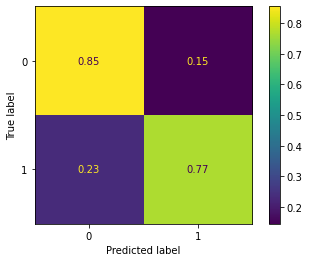

In [23]:
y_preds = final_model_pipe.predict(X_test)
labels=final_model_pipe.classes_
cm = confusion_matrix(y_test, y_preds, labels=labels, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

In [24]:
print(classification_report(y_test, y_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     84744
           1       0.84      0.77      0.80     84461

    accuracy                           0.81    169205
   macro avg       0.81      0.81      0.81    169205
weighted avg       0.81      0.81      0.81    169205



In [74]:
feature_names = final_model_pipe.named_steps['final_text'].named_steps['cv'].get_feature_names_out()
final_model_coefs = final_model_pipe.named_steps['final_model'].coef_[0]
feature_coefs = dict(zip(feature_names, final_model_coefs))
top_feature_coefs = dict(sorted(feature_coefs.items(), key=lambda x:x[1], reverse=True)[:20])

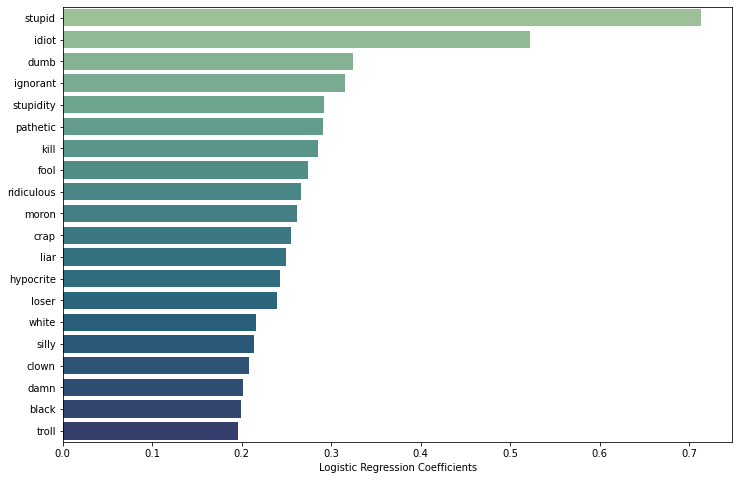

In [79]:
plt.figure(figsize=(12, 8))
sns.barplot(
    x=list(top_feature_coefs.values()),
    y=list(top_feature_coefs.keys()),
    palette='crest'
)
plt.xlabel("Logistic Regression Coefficients");
#plt.savefig('images/logistic_regression_coefs.jpg', transparent = False, bbox_inches="tight");

In [80]:
# pickle_out = open("data/final_model_pipe.pkl", mode = "wb") 
# pickle.dump(final_model_pipe, pickle_out) 
# pickle_out.close()

In [87]:
def detect(text):
    pred = final_model_pipe.predict(pd.Series([text]))
    if   pred == 0:
        print("not a toxic comment")
    elif pred == 1:
        print("toxic comment")
    else:
        print("could not get prediction for comment: ", text)
    return None

In [88]:
detect("You're a stupid idiot")

toxic comment


In [89]:
detect('You are awesome and I love you')

not a toxic comment


In [92]:
detect('Damn, I love you silly')

toxic comment
